# RNN for text classification

### Classifying spam sms

![text labeled as ham and spam](https://imgur.com/LqlmvJQ.jpg)

A Summary of the dataset we'll be using can be found [here](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/).

In [103]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional

In [104]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))#to expand the size of my container so it can take fill up my entire monitor

### Reading the data

In [105]:
# Load data

df = pd.read_csv('data/SMSSpamCollection.txt', sep = '\t', header = None,
                names = ['label', 'text'])

In [106]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploring the data

In [107]:
# look at the shape of your data
df.shape

(5572, 2)

In [108]:
# view the first 5 and last 5 rows
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [109]:
df.tail()

,label,text
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [110]:
# look at the class distribution
df['label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

### Preprocessing

In [111]:
# Remove Stopwords and create two lists containing sms' and labels
STOPWORDS = set(stopwords.words('english'))

In [112]:
messages = []
labels = []

for index, row in df.iterrows():
    labels.append(row['label'])
    
    token_list = [x for x in row['text'].split() if x not in STOPWORDS]
    
    messages.append(" ".join(token_list))

### Train test split

In [113]:
X_train, X_test, y_train, y_test = train_test_split(messages, labels, random_state=52, test_size = 0.2, stratify=labels)

### Tokenization and word indexing

In [114]:
# Define some variables
vocab_size = 5000 # max number of words
embedding_dim = 64 #Word Vector Dimension
#each word is represented by a vector of number 
#and the dimension of the vector is repped by this number (in this instance it's 64)
max_length = 200 #Max length of the sequence
trunc_type = 'post' #where to chop off the sequence
padding_type = 'post' # where to put the padding
oov_tok = '<OOV>' #replace out of vocab tokens w/ oov

In [115]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

### Converting words to numbers

In [116]:
train_seq = tokenizer.texts_to_sequences(X_train)

In [117]:
test_seq = tokenizer.texts_to_sequences(X_test)

### Adding padding

In [118]:
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [119]:
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Encoding labels

In [120]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [121]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

### Modeling

Train an RNN to classify the text.

In [122]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True))) #if you have an LSTM after this you need to have return_sequences = True
model.add(Bidirectional(LSTM(32)))
# model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 64)           320000    
                                                                 
 bidirectional_20 (Bidirecti  (None, 200, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 2)                 130       
                                                                 
Total params: 431,554
Trainable params: 431,554
Non-t

In [123]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

In [124]:
history = model.fit(train_padded, y_train, validation_data=(test_padded, y_test), batch_size = 256, epochs = 10)

Epoch 1/10
18/18 [==============================] - 33s 1s/step - loss: 0.5199 - acc: 0.8658 - val_loss: 0.3736 - val_acc: 0.8664
Epoch 2/10
18/18 [==============================] - 25s 1s/step - loss: 0.3139 - acc: 0.8658 - val_loss: 0.2122 - val_acc: 0.8664
Epoch 3/10
18/18 [==============================] - 25s 1s/step - loss: 0.1430 - acc: 0.9464 - val_loss: 0.0823 - val_acc: 0.9812
Epoch 4/10
18/18 [==============================] - 25s 1s/step - loss: 0.0485 - acc: 0.9904 - val_loss: 0.0458 - val_acc: 0.9892
Epoch 5/10
18/18 [==============================] - 27s 2s/step - loss: 0.0187 - acc: 0.9966 - val_loss: 0.0503 - val_acc: 0.9901
Epoch 6/10
18/18 [==============================] - 26s 1s/step - loss: 0.0127 - acc: 0.9975 - val_loss: 0.0339 - val_acc: 0.9910
Epoch 7/10
18/18 [==============================] - 25s 1s/step - loss: 0.0065 - acc: 0.9982 - val_loss: 0.0342 - val_acc: 0.9910
Epoch 8/10
18/18 [==============================] - 25s 1s/step - loss: 0.0027 - acc: 0.99

Plot our model's training loss, validation loss, training accuracy, and validation accuracy in a figure.

In [126]:
import matplotlib.pyplot as plt

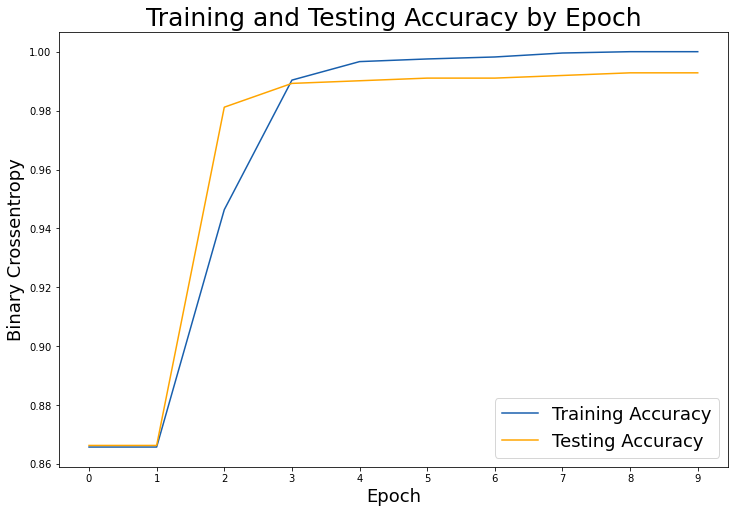

In [127]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='#185fad')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks(np.arange(10), np.arange(10))

plt.legend(fontsize = 18);